In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.ml.stat import Correlation


#pd.set_option('display.max_columns', None)

spark = spark = SparkSession \
    .builder \
    .appName("CCproject") \
    .getOrCreate()

In [2]:
circuits_schema= StructType([
    StructField("circuitId", IntegerType(), True),
    StructField("circuitRef", StringType(), True),
    StructField("name", StringType(), True),
    StructField("location", StringType(), True),
    StructField("country", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lng", DoubleType(), True),
    StructField("alt", IntegerType(), True),
    StructField("url", StringType(), True)
])
    
drivers_schema= StructType([
    StructField("driverId", IntegerType(), True),
    StructField("driverRef", StringType(), True),
    StructField("number", IntegerType(), True),
    StructField("code", StringType(), True),
    StructField("forename", StringType(), True),
    StructField("surname", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("nationality", StringType(), True),
    StructField("url", StringType(), True)
])

driver_standings_schema= StructType([
    StructField("driverStandingsId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("driverId", IntegerType(), True),
    StructField("points", DoubleType(), True),
    StructField("position", IntegerType(), True),
    StructField("positionText", StringType(), True),
    StructField("wins", IntegerType(), True)
])

quali_schema= StructType([
    StructField("qualifyId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("driverId", IntegerType(), True),
    StructField("constructorId", IntegerType(), True),
    StructField("number", IntegerType(), True),
    StructField("position", IntegerType(), True),
    StructField("q1", StringType(), True),
    StructField("q2", StringType(), True),
    StructField("q3", StringType(), True)
])


pitstops_schema= StructType([
    StructField("raceId", IntegerType(), True),
    StructField("driverId", IntegerType(), True),
    StructField("stop", IntegerType(), True),
    StructField("lap", IntegerType(), True),
    StructField("time", StringType(), True),
    StructField("duration", StringType(), True),
    StructField("milliseconds", IntegerType(), True)
])

races_schema= StructType([
    StructField("raceId", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("round", IntegerType(), True),
    StructField("circuitId", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("date", DateType(), True),
    StructField("time", StringType(), True),
    StructField("url", StringType(), True),
    StructField("fp1_date", DateType(), True),
    StructField("fp1_time", StringType(), True),
    StructField("fp2_date", DateType(), True),
    StructField("fp2_time", StringType(), True),
    StructField("fp3_date", DateType(), True),
    StructField("fp3_time", StringType(), True),
    StructField("quali_date", DateType(), True),
    StructField("quali_time", StringType(), True),
    StructField("sprint_date", DateType(), True),
    StructField("sprint_time", StringType(), True)
])

results_schema= StructType([
    StructField("resultId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("driverId", IntegerType(), True),
    StructField("constructorId", IntegerType(), True),
    StructField("number", IntegerType(), True),
    StructField("grid", IntegerType(), True),
    StructField("position", IntegerType(), True),
    StructField("positionText", StringType(), True),
    StructField("positionOrder", IntegerType(), True),
    StructField("points", DoubleType(), True),
    StructField("laps", IntegerType(), True),
    StructField("time", StringType(), True),
    StructField("milliseconds", IntegerType(), True),
    StructField("fastestLap", IntegerType(), True),
    StructField("rank", IntegerType(), True),
    StructField("fastestLapTime", StringType(), True),
    StructField("fastestLapSpeed", StringType(), True),
    StructField("statusId", IntegerType(), True)
])

constructor_standings_schema= StructType([
    StructField("constructorStandingsId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("constructorId", IntegerType(), True),
    StructField("points", DoubleType(), True),
    StructField("position", IntegerType(), True),
    StructField("positionText", StringType(), True),
    StructField("wins", IntegerType(), True)
])

constructor_results_schema= StructType([
    StructField("constructorResultsId", IntegerType(), True),
    StructField("raceId", IntegerType(), True),
    StructField("constructorId", IntegerType(), True),
    StructField("points", IntegerType(), True),
    StructField("status", StringType(), True)
])

constructors_schema= StructType([
    StructField("constructorId", IntegerType(), True),
    StructField("constructorRef", StringType(), True),
    StructField("name", StringType(), True),
    StructField("nationality", StringType(), True),
    StructField("url", StringType(), True)
])


In [3]:
circuits= spark.read.csv("hdfs://namenode:8020/f1data/circuits.csv", header=True, schema=circuits_schema)
drivers= spark.read.csv("hdfs://namenode:8020/f1data/drivers.csv", header=True, schema=drivers_schema)
driver_standings= spark.read.csv("hdfs://namenode:8020/f1data/driver_standings.csv", header=True, schema=driver_standings_schema)
quali= spark.read.csv("hdfs://namenode:8020/f1data/qualifying.csv", header=True, schema=quali_schema)
pitstops= spark.read.csv("hdfs://namenode:8020/f1data/pit_stops.csv", header=True, schema=pitstops_schema)
races= spark.read.csv("hdfs://namenode:8020/f1data/races.csv", header=True, schema=races_schema)
results= spark.read.csv("hdfs://namenode:8020/f1data/results.csv", header=True, schema=results_schema)
constructor_standings= spark.read.csv("hdfs://namenode:8020/f1data/constructor_standings.csv", header=True, schema=constructor_standings_schema)
constructors= spark.read.csv("hdfs://namenode:8020/f1data/constructors.csv", header=True, schema=constructors_schema)

Showing the columns headings for each data frame:

# EDA

1. Handling Missing Values and Cleaning the data:

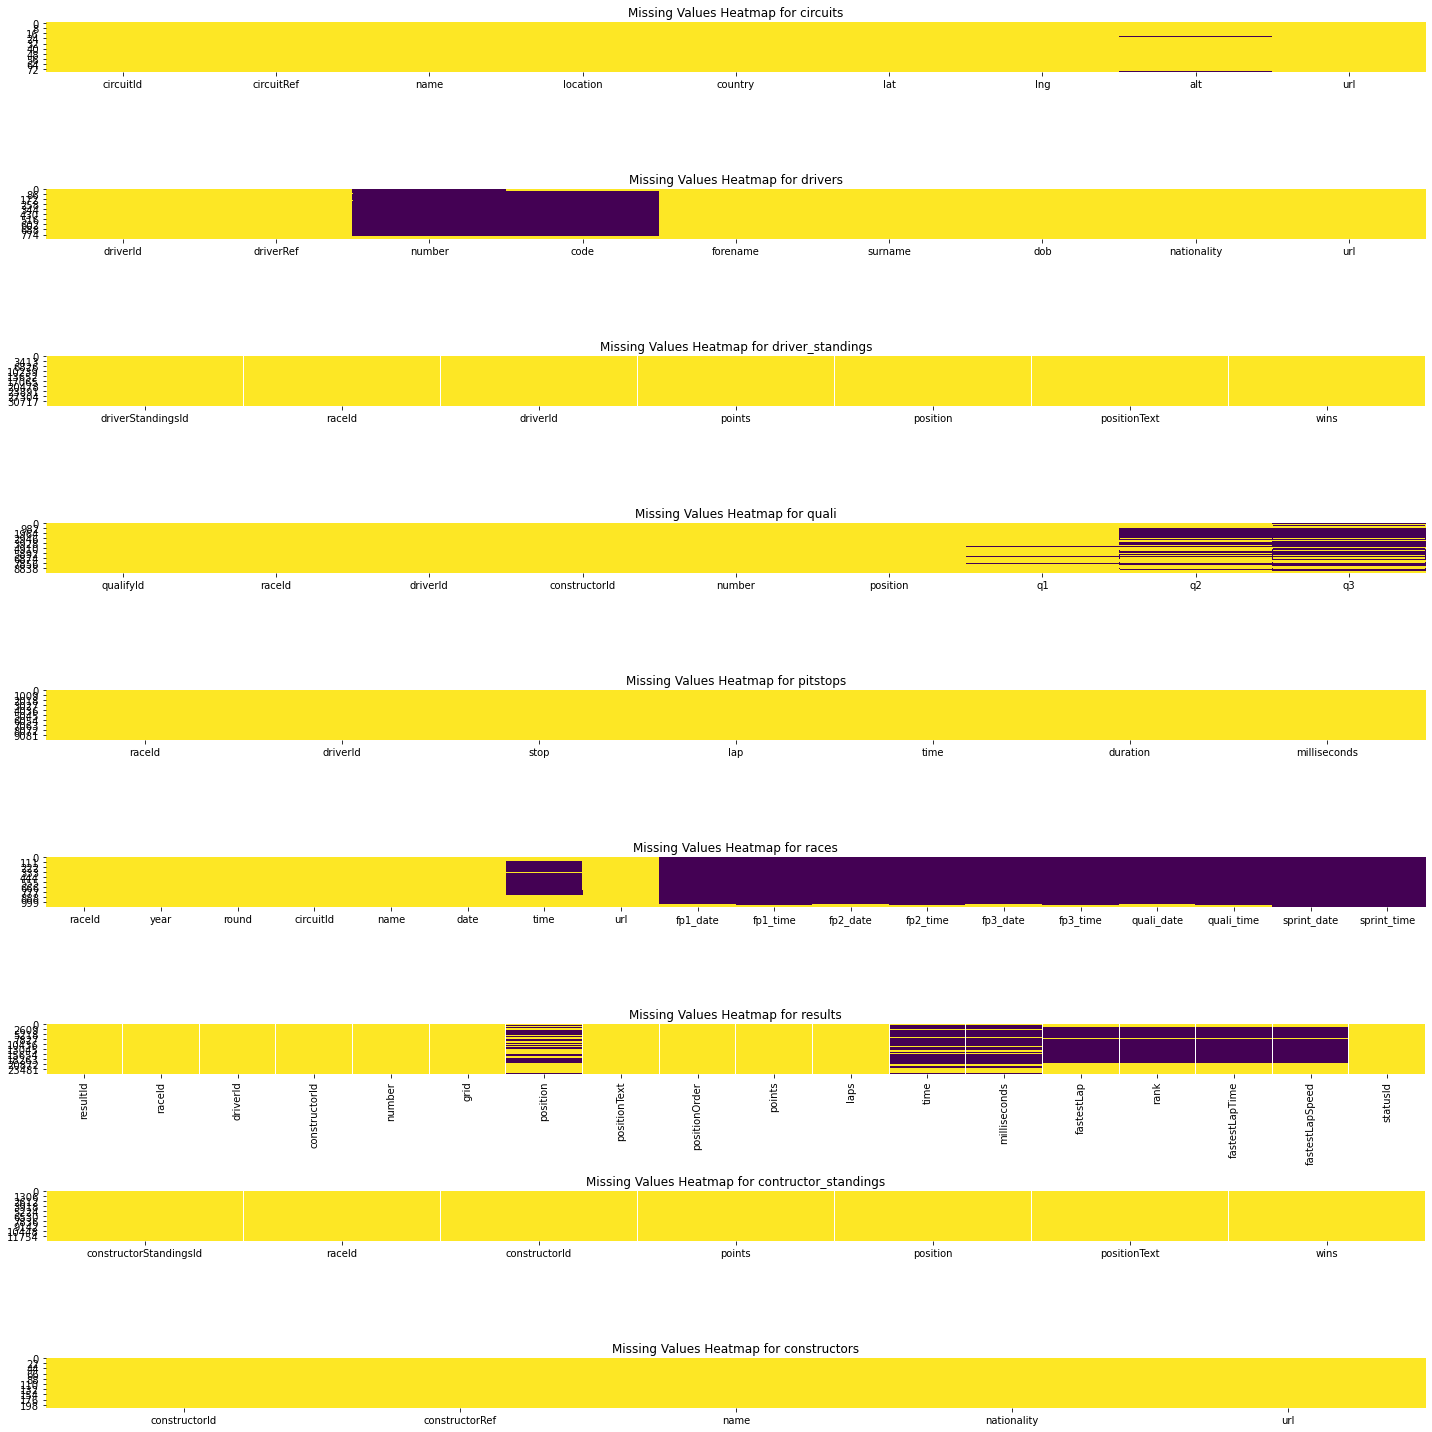

In [4]:
dataframes = [circuits, drivers, driver_standings, quali, pitstops, races, results, constructor_standings, constructors]
dataframe_names = ['circuits', 'drivers', 'driver_standings', 'quali', 'pitstops', 'races', 'results', 'contructor_standings', 'constructors']
fig, axes = plt.subplots(len(dataframes), 1, figsize=(20, 20))

for idx, (df, df_name) in enumerate(zip(dataframes, dataframe_names)):
    
    for column_name in df.columns:
        df = df.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
    missing_values = df.select([col(c).isNull().alias(c) for c in df.columns])
    missing_values_pd = missing_values.toPandas()
    
    sns.heatmap(missing_values_pd, cmap='viridis_r', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'Missing Values Heatmap for {df_name}')

plt.tight_layout()
plt.show()

From the above diagram we can see that the following dataframes have missing values:
circuits, quali, drivers, races and results

Thus let's look at these in further detail:

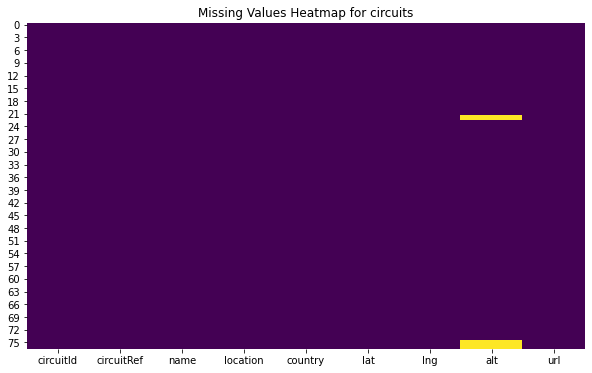

In [5]:
for column_name in circuits.columns:
    circuits = circuits.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))

missing_values_circuits = circuits.select([col(c).isNull().alias(c) for c in circuits.columns])

missing_values_pd_circuits = missing_values_circuits.toPandas()

plt.figure(figsize=(10 ,6))
sns.heatmap(missing_values_pd_circuits, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for circuits')
plt.show()

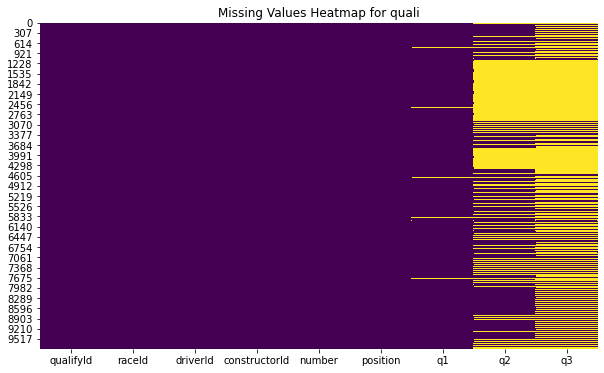

In [6]:
for column_name in quali.columns:
    quali = quali.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
missing_values_quali = quali.select([col(c).isNull().alias(c) for c in quali.columns])

missing_values_pd_quali = missing_values_quali.toPandas()

plt.figure(figsize=(10 ,6))
sns.heatmap(missing_values_pd_quali, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for quali')
plt.show()

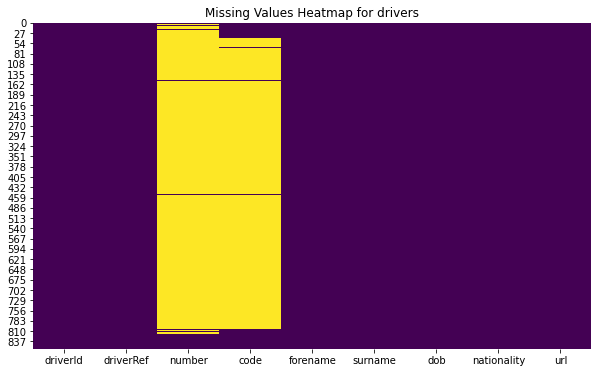

In [7]:
for column_name in drivers.columns:
    drivers = drivers.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))

missing_values_drivers = drivers.select([col(c).isNull().alias(c) for c in drivers.columns])

missing_values_pd_drivers = missing_values_drivers.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_pd_drivers, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for drivers')
plt.show()

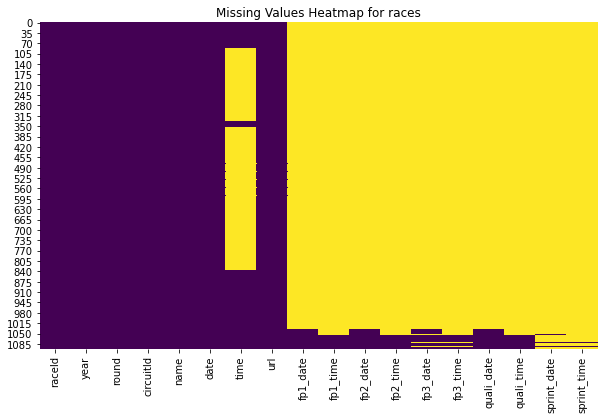

In [8]:
for column_name in races.columns:
    races = races.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
missing_values_races = races.select([col(c).isNull().alias(c) for c in races.columns])

missing_values_pd_races = missing_values_races.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_pd_races, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for races')
plt.show()

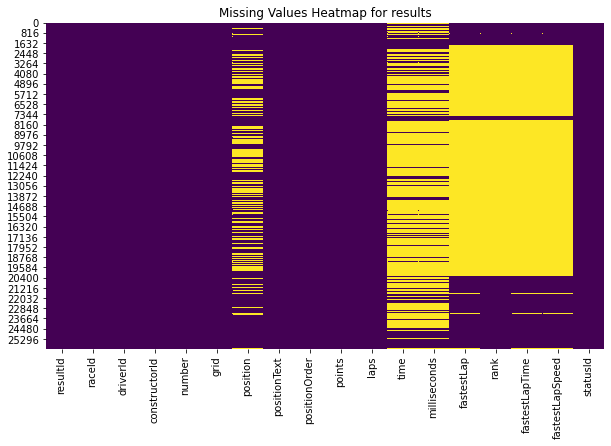

In [9]:
for column_name in results.columns:
    results = results.withColumn(column_name, when(col(column_name) == "\\N", None).otherwise(col(column_name)))
    
missing_values_results = results.select([col(c).isNull().alias(c) for c in results.columns])

missing_values_pd_results = missing_values_results.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_values_pd_results, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap for results')
plt.show()

All the columns containing missing values in the circuits, drivers, races and results data frames are not required for the EDA. Thus, we can delete these columns:

In [10]:
circuits= circuits.drop("alt")
drivers= drivers.drop("number", "code")
races= races.drop("fp1_date","fp1_time", "fp2_date", "fp2_time", "fp3_date", "fp3_time", "quali_date","quali_time", "sprint_date", "sprint_time","time")
results= results.drop("number", "position","time" ,"milliseconds", "fastestLap", "fastestLapTime","fastestLapSpeed", "rank", "status")

In [11]:
results.count()

26080

- Dealing with the missing values in thr quali dataframe:
I want to find the fastest quali time. Let's create a new column that contains the fastest time from q1, q2, q3:

In [12]:
for column_name in quali.columns:
    quali = quali.withColumn(column_name, when(col(column_name) == None, 0).otherwise(col(column_name)))

quali= quali.withColumn("fastest_lap_time", least(quali["q1"], quali["q2"], quali["q3"]))
quali.head()
quali= quali.drop("constructorId")

In [13]:
quali.count()

9815

Now, as there are no missing values remaining, data imputation is not required

2. We can now begin finding the data trends between all the variables in the dataset:

- Firstly, lets look at the results dataset to find which driver has had the most number of wins in F1 since the 1950s:

In [14]:
most_wins= results.drop("positionText", "laps", "statusId")
most_wins= most_wins.join(races, "raceId", "inner")
most_wins= most_wins.drop("round", "date", "url")

#most_wins= most_wins.join(quali, ['driverId', 'raceId'], 'inner')

most_wins= most_wins.join(drivers, "driverId", "inner")
most_wins= most_wins.withColumn("full_name", concat(col("forename"), lit(" "), col("surname")))
most_wins= most_wins.drop("driverRef", "code", "dob", "url")

In [15]:
most_wins.head()

Row(driverId=1, raceId=18, resultId=1, constructorId=1, grid=1, positionOrder=1, points=10.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Lewis', surname='Hamilton', nationality='British', full_name='Lewis Hamilton')

In [16]:
most_wins.count()

26080

In [17]:
# missing_values_most_wins = most_wins.select([col(c).isNull().alias(c) for c in most_wins.columns])

# missing_values_pd_most_wins = missing_values_most_wins.toPandas()

# plt.figure(figsize=(10 ,6))
# sns.heatmap(missing_values_pd_most_wins, cmap='viridis', cbar=False)
# plt.title('Missing Values Heatmap for most_wins')
# plt.show()

In [18]:
first_place_results = most_wins.filter(col("positionOrder") == 1)
driver_win_count = first_place_results.groupBy("driverId", "full_name").count()

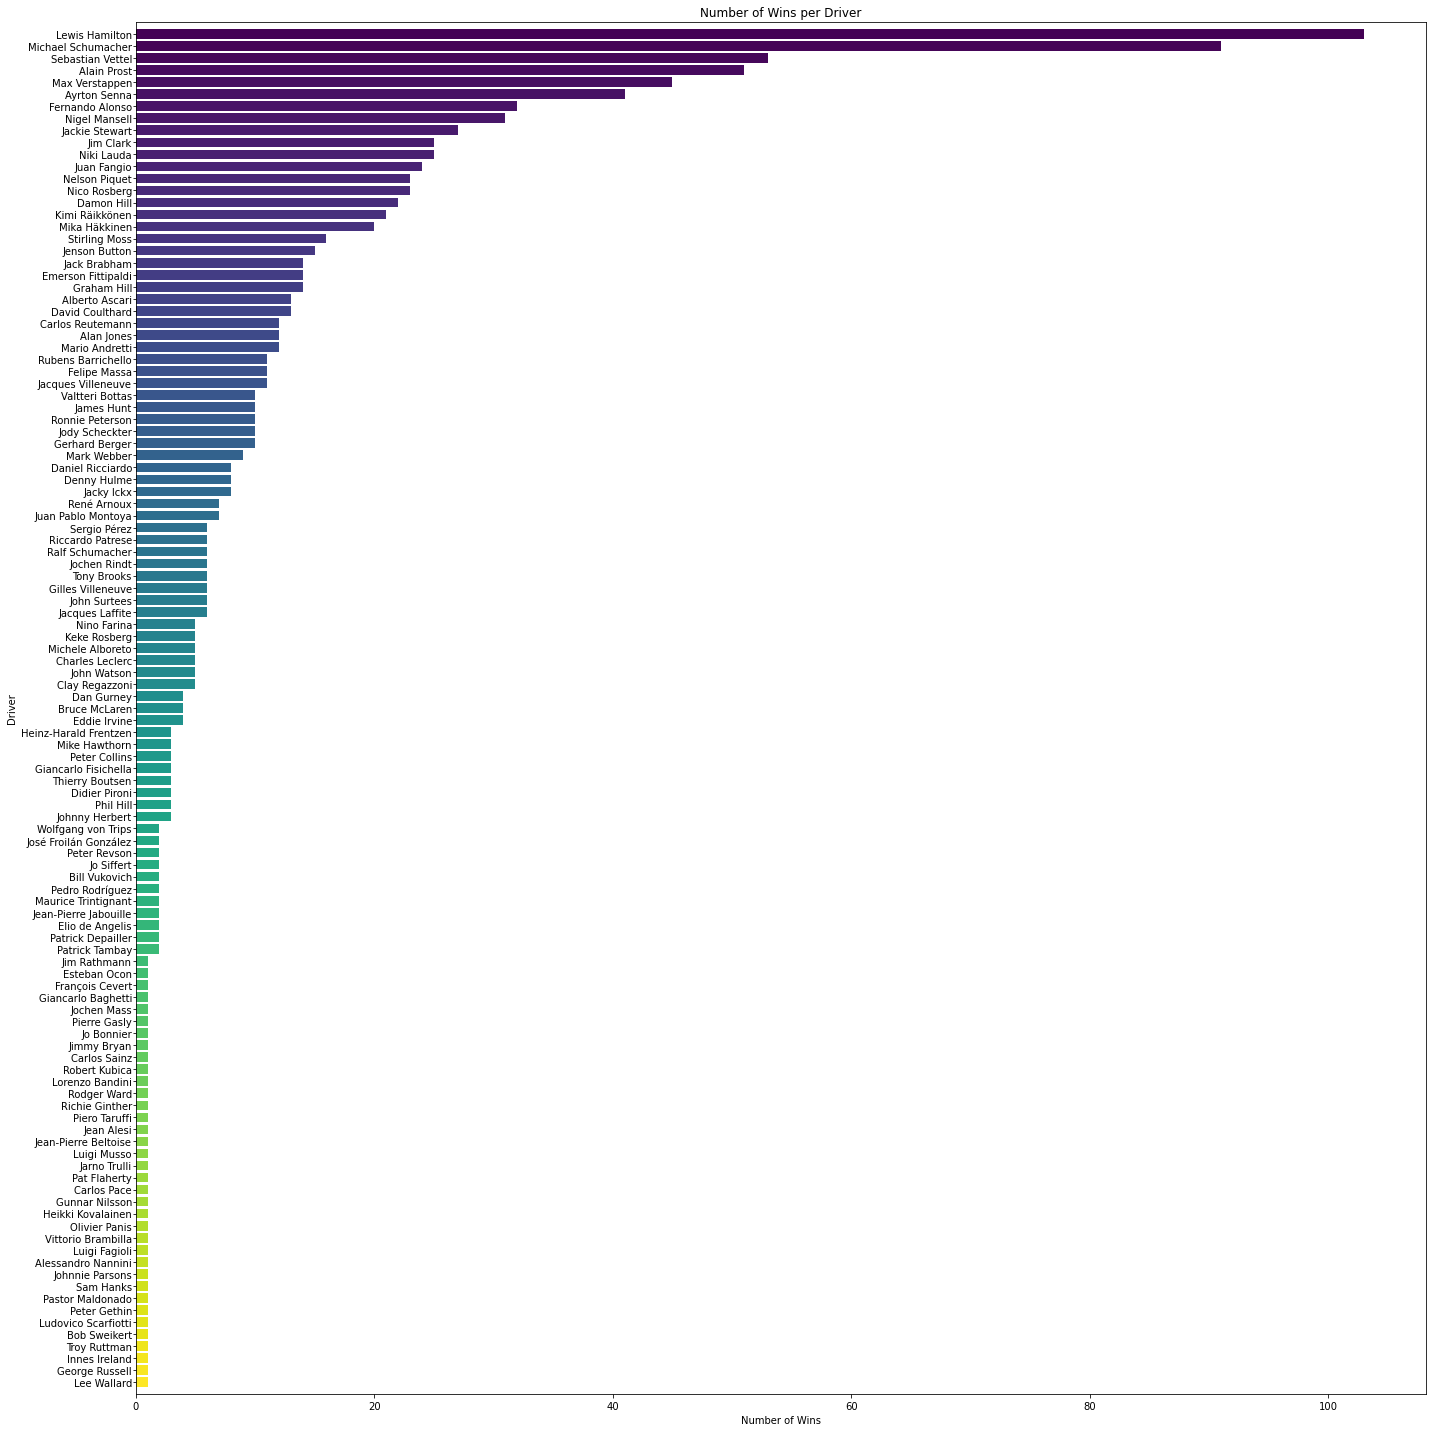

In [19]:
import numpy as np
driver_win_count_pd = driver_win_count.toPandas()
driver_win_count_pd = driver_win_count_pd.sort_values(by="count", ascending=True)

colors = plt.cm.viridis_r(np.linspace(0, 1, len(driver_win_count_pd)))

bar_gap = 0.15
plt.figure(figsize=(20, 20))
plt.barh(driver_win_count_pd["full_name"], driver_win_count_pd["count"], align='center', color=colors)
plt.xlabel("Number of Wins")
plt.ylabel("Driver")
plt.title("Number of Wins per Driver")

plt.tick_params(axis='y', pad=bar_gap)
plt.margins(y=0.005)
plt.tight_layout()

plt.show()

Based on the above plot, we can see that Lewis Hamilton, Michael Schumacher and Sebastian Vettel have won the most number of races.

- Next, lets look at which team has won the constuctor championship each year:

In [20]:
constructors= constructors.drop("nationality")
constructors= constructors.withColumnRenamed('name', 'team_name')
constructor_wins= most_wins.join(constructors, "constructorId", "inner")
constructor_wins= constructor_wins.drop("constructorRef", "url")
constructor_wins.head(5)

[Row(constructorId=1, driverId=1, raceId=18, resultId=1, grid=1, positionOrder=1, points=10.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Lewis', surname='Hamilton', nationality='British', full_name='Lewis Hamilton', team_name='McLaren'),
 Row(constructorId=2, driverId=2, raceId=18, resultId=2, grid=5, positionOrder=2, points=8.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Nick', surname='Heidfeld', nationality='German', full_name='Nick Heidfeld', team_name='BMW Sauber'),
 Row(constructorId=3, driverId=3, raceId=18, resultId=3, grid=7, positionOrder=3, points=6.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Nico', surname='Rosberg', nationality='German', full_name='Nico Rosberg', team_name='Williams'),
 Row(constructorId=4, driverId=4, raceId=18, resultId=4, grid=11, positionOrder=4, points=5.0, year=2008, circuitId=1, name='Australian Grand Prix', forename='Fernando', surname='Alonso', nationality='Spanish', full_name='Fern

In [21]:
team_points= constructor_wins.groupBy('year', 'team_name').agg(sum('points').alias('total_points'))

max_points_team= team_points.groupBy('year').agg(max('total_points').alias('max_points'))
max_points_team= max_points_team.withColumnRenamed('year', 'extra_year')

constructors_championship= team_points.join(max_points_team, (team_points['year'] == max_points_team['extra_year']) & (team_points['total_points'] == max_points_team['max_points']))
constructors_championship= constructors_championship.drop("max_points", "extra_year")

constructors_championship.head(5)

[Row(year=1973, team_name='Tyrrell', total_points=118.0),
 Row(year=1978, team_name='Team Lotus', total_points=116.0),
 Row(year=1986, team_name='Williams', total_points=141.0),
 Row(year=1965, team_name='BRM', total_points=81.0),
 Row(year=2009, team_name='Brawn', total_points=172.0)]

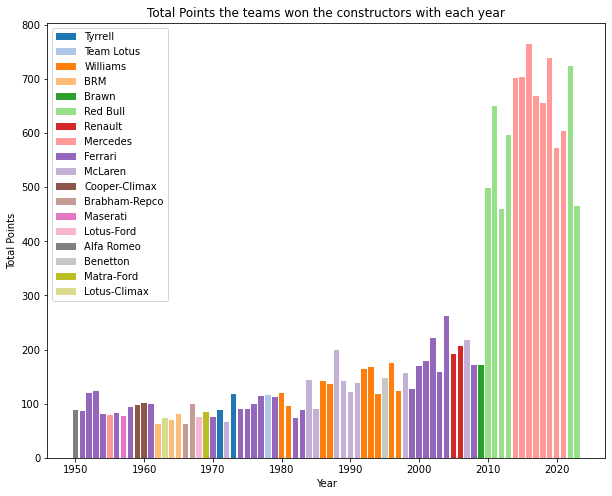

In [22]:
counstructor_count_pd = constructors_championship.toPandas()
#counstructor_count_pd = counstructor_count_pd.sort_values(by="total_points", ascending=True)

team_colors = sns.color_palette("tab20", n_colors=len(counstructor_count_pd['team_name'].unique()))


plt.figure(figsize=(10, 8))
for i, team in enumerate(counstructor_count_pd['team_name'].unique()):
    team_data = counstructor_count_pd[counstructor_count_pd['team_name'] == team]
    plt.bar(team_data['year'], team_data['total_points'], color=team_colors[i], label=team)

plt.xlabel('Year')
plt.ylabel('Total Points')
plt.title('Total Points the teams won the constructors with each year')
plt.legend()

plt.show()

-  Now, lets plot which team has won the constructor the most:

In [23]:
team_mentions= constructors_championship.groupBy("team_name").agg(count("*").alias("Number of constructor_championships"))

In [24]:
team_mentions_pd= team_mentions.toPandas()
team_mentions_pd= team_mentions_pd.sort_values(by="Number of constructor_championships", ascending=True)
#team_mentions_pd.head()

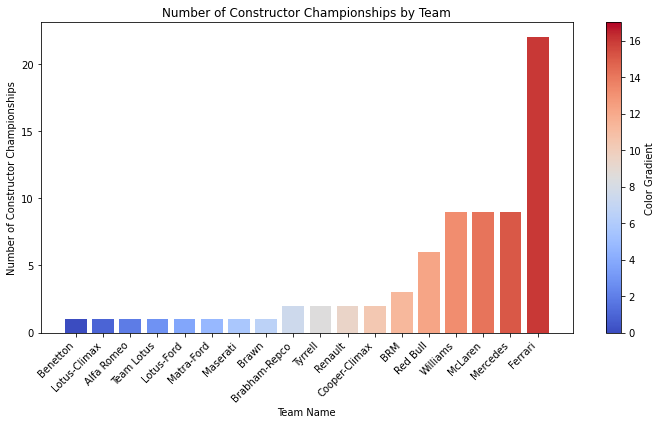

In [25]:
cmap = plt.get_cmap('coolwarm')
plt.figure(figsize=(10, 6))
bars = plt.bar(
    team_mentions_pd["team_name"], team_mentions_pd["Number of constructor_championships"], 
    color=[cmap(i / len(team_mentions_pd["team_name"])) for i in range(len(team_mentions_pd["team_name"]))]
)
#plt.bar(team_mentions_pd["team_name"], team_mentions_pd["Number of constructor_championships"], color='skyblue')
plt.xlabel('Team Name')
plt.ylabel('Number of Constructor Championships')
plt.title('Number of Constructor Championships by Team')
plt.xticks(rotation=45, ha="right")  # Rotate X-axis labels for better visibility
plt.tight_layout()  # Adjust layout for labels

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(team_mentions_pd["team_name"])-1))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Color Gradient')
plt.show()

- Let's now find which driver has won the driver's the constructor the most and which team were they a part of when they won each one:

In [26]:
driver_points = constructor_wins.groupBy('year','full_name','team_name').agg(sum('points').alias('total_points'))

max_points_driver= driver_points.groupBy('year').agg(max('total_points').alias('max_points'))
max_points_driver= max_points_driver.withColumnRenamed('year', 'extra_year')

drivers_championship= driver_points.join(max_points_driver, (driver_points['year'] == max_points_driver['extra_year']) & (driver_points['total_points'] == max_points_driver['max_points']))
drivers_championship= drivers_championship.drop("max_points", "extra_year")

# driver_mentions= drivers_championship.groupBy("full_name").agg(count("*").alias("Number of driver_championships"))

championships_per_team = drivers_championship.groupBy("full_name", "team_name").agg(count("*").alias("driver_championships"))

championships_per_team.head(5)

[Row(full_name='Mika Häkkinen', team_name='McLaren', driver_championships=2),
 Row(full_name='Michael Schumacher', team_name='Ferrari', driver_championships=5),
 Row(full_name='Jack Brabham', team_name='Cooper-Climax', driver_championships=2),
 Row(full_name='Graham Hill', team_name='BRM', driver_championships=2),
 Row(full_name='Juan Fangio', team_name='Mercedes', driver_championships=2)]

<Figure size 720x432 with 0 Axes>

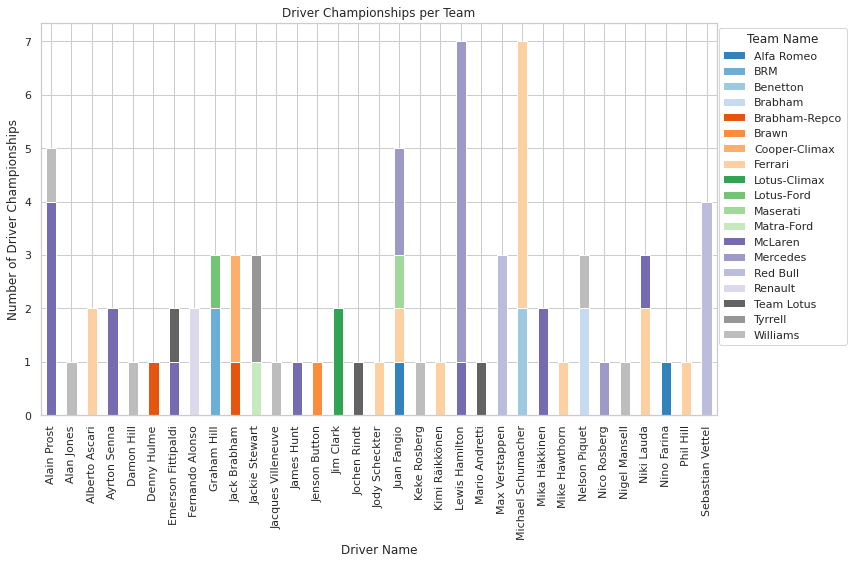

In [27]:
driver_championships_pd= championships_per_team.toPandas()
pivot_df = driver_championships_pd.pivot(index='full_name', columns='team_name', values='driver_championships').fillna(0)

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("tab20c", n_colors=len(pivot_df.columns))

pivot_df.plot(kind='bar', stacked=True, color=palette, figsize=(12, 8))
plt.ylabel('Number of Driver Championships')
plt.xlabel('Driver Name')
plt.title('Driver Championships per Team')
plt.legend(title='Team Name', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

- Next, lets look at the correlations between the starting grid position, race results, pitstop times, circuit and whether the driver won or not:

Based on the analysis above, we can see that Lewis Hamilton has won the most number of races and has won the driver's championship 7 times. Thus, let's look at the stats of this driver more closely and create a machine learning model that is able to predict whether Lewis Hamilton will recieve a podium based on selected features:

In [297]:
LH_df= constructor_wins #lter(constructor_wins["full_name"]== "Lewis Hamilton")
quali = quali.withColumnRenamed("raceId", "RaceId")

LH_df = LH_df.join(quali, (LH_df.raceId == quali.RaceId)& (LH_df.driverId == quali.driverId), 'left')

# Add the 'fastest_lap_time' from quali to LH_df as 'fastest_quali_lap'
LH_df = LH_df.withColumnRenamed("fastest_lap_time", "fastest_quali_lap")

LH_df= LH_df.drop("driverId", "q1", "q2", "q3", "resultId","forename", "surname", "nationality", "number", "qualifyId", "RaceId")

LH_df= LH_df.withColumn("Classifier", F.when(LH_df["positionOrder"] == 1, "P1")
                                     .otherwise("Didn't Win"))

In [33]:
# pip install scipy

In [74]:
from scipy import stats

pandas_df = LH_df.select("constructorId", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df['constructorId'], pandas_df['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 1622.1232665181242
P-value: 7.996970076237836e-217


In [75]:
pandas_df2 = LH_df.select("grid", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df2['grid'], pandas_df2['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 5866.175079053852
P-value: 0.0


In [76]:
pandas_df3 = LH_df.select("position", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df3['position'], pandas_df3['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 2879.1935324659853
P-value: 0.0


In [77]:
pandas_df4 = LH_df.select("circuitId", 'Classifier').toPandas()

# Perform a chi-squared test
crosstab = pd.crosstab(pandas_df4['circuitId'], pandas_df4['Classifier'])
chi2, p, _, _ = stats.chi2_contingency(crosstab)

print("Chi-squared statistic:", chi2)
print("P-value:", p)

Chi-squared statistic: 10.798950623748228
P-value: 1.0


In [298]:
teams_to_include = [
    'Williams', 'Alfa Romeo', 'Red Bull', 'Mercedes', 'Haas F1 Team', 'Ferrari',
    'McLaren', 'Aston Martin', 'Racing Point', 'Torro Rosso', 'Renault', 'Alpine F1 Team', 'AlphaTauri'
]

# Filter the DataFrame
LH_df= LH_df.filter(LH_df['team_name'].isin(teams_to_include))

LH_df = LH_df.withColumn("team_name", when(LH_df["team_name"] == "Torro Rosso", "AlphaTauri").otherwise(LH_df["team_name"]))
LH_df = LH_df.withColumn("team_name", when(LH_df["team_name"] == "Racing Point", "Aston Martin").otherwise(LH_df["team_name"]))
LH_df = LH_df.withColumn("team_name", when(LH_df["team_name"] == "Renault", "Alpine F1 Team").otherwise(LH_df["team_name"]))

In [300]:
LH_df= LH_df.withColumn(
    "Classifier",
    when(col("Classifier") == "P1", 1)
    .otherwise(0)
)
LH_df.head()

Row(constructorId=1, grid=1, positionOrder=1, points=10.0, year=2008, circuitId=1, name='Australian Grand Prix', full_name='Lewis Hamilton', team_name='McLaren', position=1, fastest_quali_lap='1:25.187', Classifier=1)

In [308]:
LH_df= LH_df.filter((col("grid") > 0) & (col("grid") <= 20))

In [309]:
LH_df_pd= LH_df.toPandas()
LH_df_pd.head()

,constructorId,grid,positionOrder,points,year,circuitId,name,full_name,team_name,position,fastest_quali_lap,Classifier
0,1,1,1,10.0,2008,1,Australian Grand Prix,Lewis Hamilton,McLaren,1.0,1:25.187,1
1,3,7,3,6.0,2008,1,Australian Grand Prix,Nico Rosberg,Williams,7.0,1:26.059,0
2,4,11,4,5.0,2008,1,Australian Grand Prix,Fernando Alonso,Alpine F1 Team,12.0,1:26.188,0
3,1,3,5,4.0,2008,1,Australian Grand Prix,Heikki Kovalainen,McLaren,3.0,1:25.452,0
4,3,13,6,3.0,2008,1,Australian Grand Prix,Kazuki Nakajima,Williams,14.0,1:26.413,0


In [313]:
LH_df_pd.shape[0]

8862

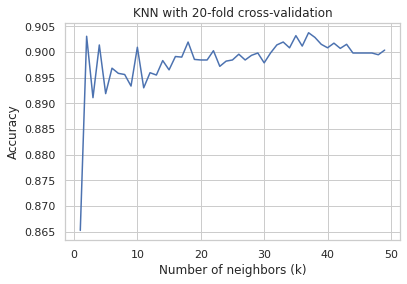

Optimal number of neighbors (k): 37
Highest accuracy: 0.9037540082455336


In [355]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Separate features and target variable
label_encoder = LabelEncoder()
LH_df_pd['constructor_encoded'] = label_encoder.fit_transform(LH_df_pd['team_name'])

X = LH_df_pd[['grid','constructor_encoded']]
y = LH_df_pd['Classifier']


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

k_values = range(1, 50)  # Range of k values to test
accuracy_scores = []  # List to store accuracy scores

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=30, scoring='accuracy')
    accuracy_scores.append(np.mean(scores))

# Plot the accuracy scores for different k values
plt.plot(k_values, accuracy_scores)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN with 20-fold cross-validation')
plt.show()

best_k = k_values[np.argmax(accuracy_scores)]
print('Optimal number of neighbors (k):', best_k)
print('Highest accuracy:', np.max(accuracy_scores))


In [356]:
knn = KNeighborsClassifier(n_neighbors=best_k)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.89


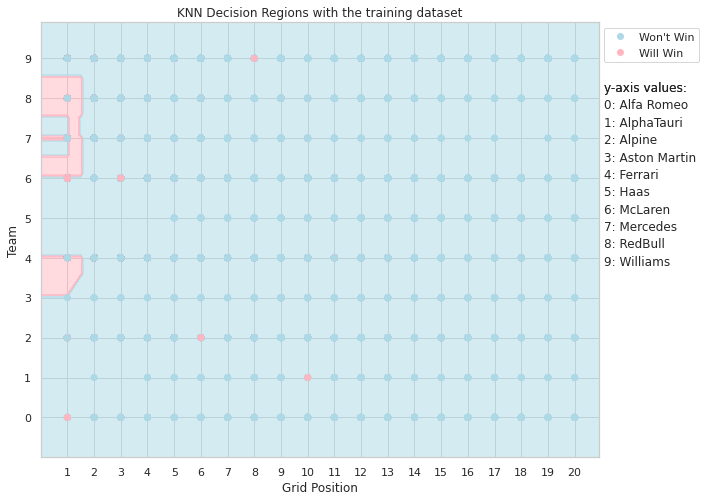

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

# Generate a meshgrid of points to plot the decision regions
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
h = 0.1  # increased step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Encode the string labels into numeric values
label_encoder = LabelEncoder()
Z = label_encoder.fit_transform(Z)

# Reshape the array and convert to float
Z = Z.reshape(xx.shape).astype(float)

# Create a colormap for the classes
cmap = ListedColormap(['lightblue', 'lightpink'])

# Encode the training labels into numeric values
y_train_encoded = label_encoder.transform(y_train)

# Plot the decision regions
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)


plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train_encoded, cmap=cmap)

custom_ticksx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
custom_ticksy = [0,1,2,3,4,5,6,7,8,9]
plt.xticks(custom_ticksx)
plt.yticks(custom_ticksy)
plt.xlabel('Grid Position')
plt.ylabel('Team')
plt.title('KNN Decision Regions with the training dataset')

# Create a legend
class_names = ["Won't Win", 'Will Win']
class_markers = ['o', 'o']
handles = [plt.Line2D([], [], marker=marker, color='w', label=name, markerfacecolor=color, markersize=8)
           for name, color, marker in zip(class_names, cmap.colors, class_markers)]
plt.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.19, 1))

y_legend_text = 'y-axis values:'
plt.text(1.01, 0.85, y_legend_text, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')

team1 = '0: Alfa Romeo'
team2 = '1: AlphaTauri'
team3 = '2: Alpine'
team4 = '3: Aston Martin'
team5 = '4: Ferrari'
team6 = '5: Haas'
team7 = '6: McLaren'
team8 = '7: Mercedes'
team9 = '8: RedBull'
team10 = '9: Williams'
plt.text(1.01, 0.85, y_legend_text, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.81, team1, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.77, team2, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.73, team3, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.69, team4, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.65, team5, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.61, team6, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.57, team7, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.53, team8, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.49, team9, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')
plt.text(1.01, 0.45, team10, transform=plt.gca().transAxes, rotation='horizontal', verticalalignment='center')


plt.show()